# XGBoost Grid Search (Single-Parameter)

This notebook runs GridSearchCV on one parameter at a time to keep runtime manageable.

In [132]:
import sys
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV, StratifiedKFold, ParameterGrid
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score
from catboost import CatBoostClassifier

# Allow imports from project root so `src` is a package
ROOT = Path('..').resolve()
if str(ROOT) not in sys.path:
    sys.path.append(str(ROOT))

from src.config import Paths, TARGET_COL


In [107]:
def _read_csv(data_dir: str, filename: str) -> pd.DataFrame:
    path = Path(data_dir) / filename
    if not path.exists():
        raise FileNotFoundError(f'Missing file: {path}')
    return pd.read_csv(path)

def _encode_target(y_raw: pd.Series) -> pd.Series:
    # Kaggle label is 'High'/'Low'. If already numeric, keep it.
    if pd.api.types.is_numeric_dtype(y_raw):
        return y_raw.astype(int)

    y_raw = y_raw.astype(str)
    label_map = {'Low': 0, 'High': 1}
    unknown = set(y_raw.unique()) - set(label_map.keys())
    if unknown:
        raise ValueError(f'Unexpected labels in {TARGET_COL}: {sorted(unknown)}')

    return y_raw.map(label_map).astype(int)

def _add_date_features(df: pd.DataFrame, col: str) -> pd.DataFrame:
    # Convert a date column into a single numeric feature: days from 2026-02-10. Drops the original column.
    if col not in df.columns:
        return df

    dt = pd.to_datetime(df[col], errors='coerce')
    ref = pd.Timestamp('2026-02-10')
    df = df.copy()
    df['days_from_2026_02_10'] = (ref - dt).dt.days
    df = df.drop(columns=[col])
    return df

def _choose_categorical_cols(X: pd.DataFrame, high_cardinality_frac: float = 0.5) -> tuple[list[str], list[str]]:
    # Split object columns into keep vs drop by cardinality.
    obj_cols = [c for c in X.columns if X[c].dtype == 'object']
    n = max(len(X), 1)

    keep, drop = [], []
    for c in obj_cols:
        nunique = X[c].nunique(dropna=True)
        if nunique > high_cardinality_frac * n:
            drop.append(c)
        else:
            keep.append(c)
    return keep, drop

def load_train(paths: Paths) -> tuple[pd.DataFrame, pd.Series]:
    train_df = _read_csv(paths.data_dir, paths.train_csv)

    if TARGET_COL not in train_df.columns:
        raise ValueError(f"Expected target column '{TARGET_COL}' in train.csv")

    y = _encode_target(train_df[TARGET_COL])
    X = train_df.drop(columns=[TARGET_COL]).copy()

    # Replace duration_ms with log_duration_ms to reduce skew
    if 'duration_ms' in X.columns:
        X['log_duration_ms'] = np.log1p(X['duration_ms'])
        X = X.drop(columns=['duration_ms'])

    # Drop explicit URL/id columns if present
    drop_cols = [c for c in ['track_href', 'uri', 'analysis_url'] if c in X.columns]
    if drop_cols:
        X = X.drop(columns=drop_cols)

    # Date feature engineering
    date_col = 'track_album_release_date'
    X = _add_date_features(X, date_col)

    # Decide which categorical columns to keep vs drop
    cat_keep, cat_drop = _choose_categorical_cols(X, high_cardinality_frac=0.5)

    # Drop high-cardinality object columns (IDs/URLs)
    if cat_drop:
        X = X.drop(columns=cat_drop)

    # One-hot encode remaining categoricals
    if cat_keep:
        X = pd.get_dummies(X, columns=cat_keep, dummy_na=True)

    return X, y

paths = Paths(data_dir=str(ROOT / 'data'))
X, y = load_train(paths)
print(X.shape, y.shape)


(3864, 16) (3864,)


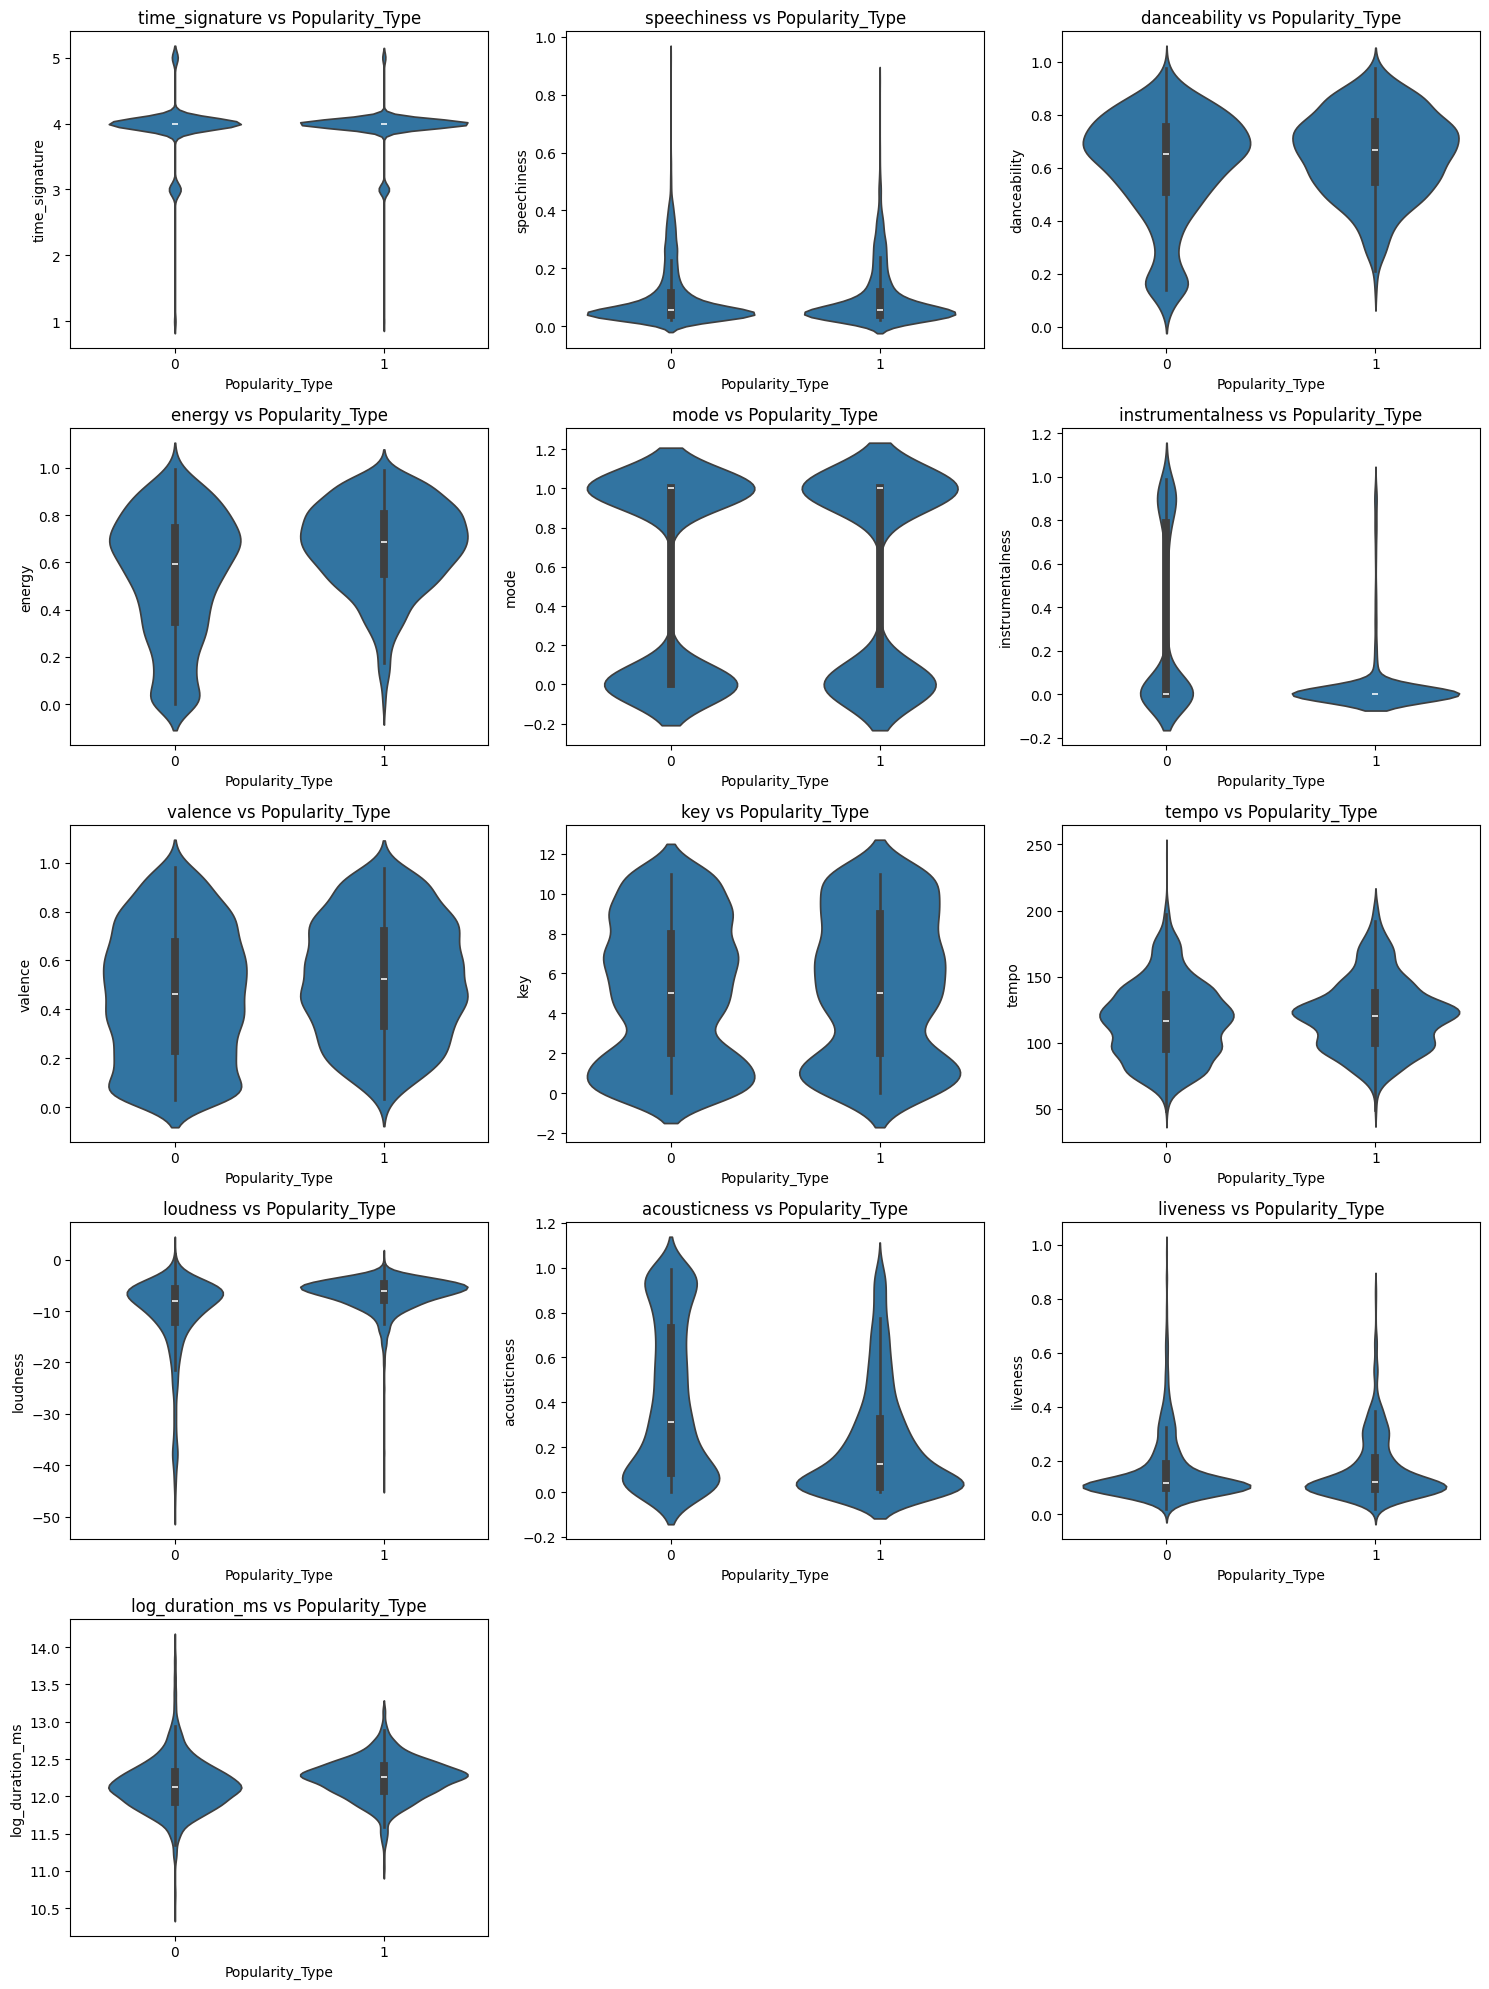

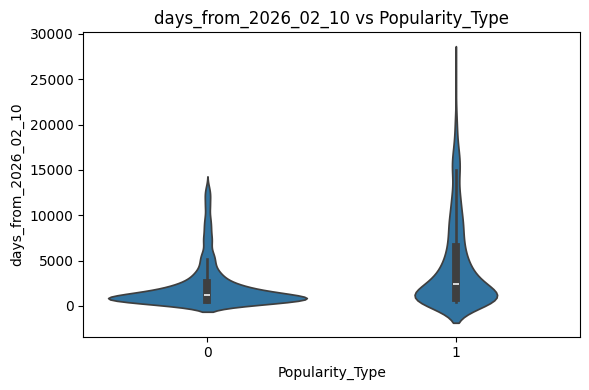

In [36]:
# Preprocess + visualize numeric features vs target
train_df = _read_csv(paths.data_dir, paths.train_csv)
# Replace duration_ms with log_duration_ms for visualization
if 'duration_ms' in train_df.columns:
    train_df['log_duration_ms'] = np.log1p(train_df['duration_ms'])
    train_df = train_df.drop(columns=['duration_ms'])
y_raw = train_df[TARGET_COL]
y_plot = _encode_target(y_raw)
numeric_cols = [c for c in train_df.columns if c != TARGET_COL and pd.api.types.is_numeric_dtype(train_df[c])]

# 1) Visualize numeric features vs Popularity_Type
if numeric_cols:
    n = len(numeric_cols)
    cols = 3
    rows = (n + cols - 1) // cols
    fig, axes = plt.subplots(rows, cols, figsize=(5 * cols, 4 * rows))
    axes = np.array(axes).reshape(-1)
    for ax, col in zip(axes, numeric_cols):
        sns.violinplot(x=y_plot, y=train_df[col], ax=ax)
        ax.set_title(f'{col} vs {TARGET_COL}')
        ax.set_xlabel(TARGET_COL)
    for ax in axes[len(numeric_cols):]:
        ax.axis('off')
    plt.tight_layout()
    plt.show()



# Date-derived numeric feature: days_from_2026_02_10 vs Popularity_Type
if 'track_album_release_date' in train_df.columns:
    dt = pd.to_datetime(train_df['track_album_release_date'], errors='coerce')
    ref = pd.Timestamp('2026-02-10')
    train_df = train_df.copy()
    train_df['days_from_2026_02_10'] = (ref - dt).dt.days
    train_df = train_df.drop(columns=['track_album_release_date'])

    if 'days_from_2026_02_10' in train_df.columns:
        plt.figure(figsize=(6, 4))
        sns.violinplot(x=y_plot, y=train_df['days_from_2026_02_10'])
        plt.title(f'days_from_2026_02_10 vs {TARGET_COL}')
        plt.xlabel(TARGET_COL)
        plt.tight_layout()
        plt.show()


params={'colsample_bytree': 1.0, 'gamma': 0.8, 'learning_rate': 0.05, 'max_depth': 9, 'min_child_weight': 0.5, 'n_estimators': 300, 'reg_alpha': 0.5, 'reg_lambda': 0.8, 'subsample': 0.8} mean_auc=0.838857 std_auc=0.007496
[{'params': {'colsample_bytree': 1.0, 'gamma': 0.8, 'learning_rate': 0.05, 'max_depth': 9, 'min_child_weight': 0.5, 'n_estimators': 300, 'reg_alpha': 0.5, 'reg_lambda': 0.8, 'subsample': 0.8}, 'mean_auc': 0.838857473353705, 'std_auc': 0.007495823397902524, 'fold_auc': [0.8435702125161442, 0.847749354232711, 0.8425061641423036, 0.8272719267347659, 0.8331897091426004]}]
{'colsample_bytree': 1.0, 'gamma': 0.8, 'learning_rate': 0.05, 'max_depth': 9, 'min_child_weight': 0.5, 'n_estimators': 300, 'reg_alpha': 0.5, 'reg_lambda': 0.8, 'subsample': 0.8}


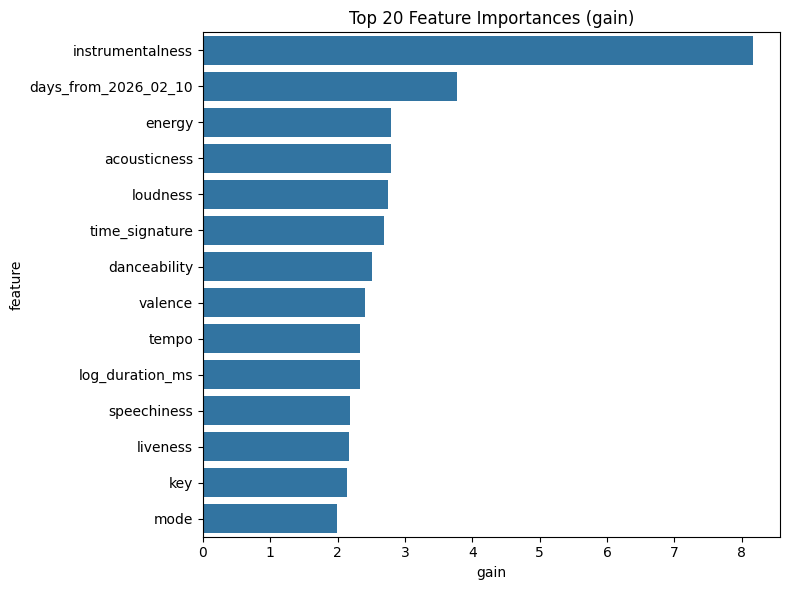

In [128]:
# Grid Search with early stopping per CV fold
params = {
    'min_child_weight': [0.5],
    'gamma': [0.8],
    'subsample': [0.8],
    'colsample_bytree': [1.0],
    'n_estimators': [300],
    'max_depth': [9],
    'learning_rate': [0.05],
    'reg_alpha': [0.5],
    'reg_lambda': [0.8],
}
# params['min_child_weight'] = [0.3,0.4,0.5,0.6,0.7,3,5,7,9]
# params['gamma'] = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1,2,5]
# params['subsample'] = [0.4,0.5,0.6, 0.7, 0.8,0.9,1.0]
# params['colsample_bytree'] = [0.6, 0.7, 0.8, 0.9, 1.0]
# params['n_estimators'] = [100,200,300,400,500,600]
# params['max_depth'] = [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
# params['learning_rate'] = [0.01,0.02,0.03,0.04, 0.05, 0.06, 0.07, 0.08, 0.09]
# params['reg_alpha'] = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]
# params['reg_lambda'] = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]

Y = y.values.ravel()

folds = 5
skf = StratifiedKFold(n_splits=folds, shuffle=True, random_state=1001)

results = []
best_score = -np.inf
best_params = None

for param in ParameterGrid(params):
    fold_scores = []
    for fold_id, (train_idx, val_idx) in enumerate(skf.split(X, Y), start=1):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = Y[train_idx], Y[val_idx]

        model = XGBClassifier(
            objective='binary:logistic',
            eval_metric='auc',
            tree_method='hist',
            random_state=1000 + fold_id,
            n_jobs=4,
            **param,
        )
        model.fit(
            X_train,
            y_train,
            eval_set=[(X_val, y_val)],
            verbose=False,
        )

        preds = model.predict_proba(X_val)[:, 1]
        fold_scores.append(roc_auc_score(y_val, preds))

    mean_score = float(np.mean(fold_scores))
    std_score = float(np.std(fold_scores))
    print(f"params={param} mean_auc={mean_score:.6f} std_auc={std_score:.6f}")

    results.append({
        'params': param,
        'mean_auc': mean_score,
        'std_auc': std_score,
        'fold_auc': fold_scores,
    })

    if mean_score > best_score:
        best_score = mean_score
        best_params = param

print(results)
print(best_params)

# Train final model with best params and plot gain-based feature importance
if best_params is not None:
    final_model = XGBClassifier(
        objective='binary:logistic',
        eval_metric='auc',
        tree_method='hist',
        random_state=0,
        n_jobs=4,
        **best_params,
    )
    final_model.fit(X, Y, verbose=False)

    booster = final_model.get_booster()
    score = booster.get_score(importance_type='gain')
    if score:
        imp = (
            pd.DataFrame({'feature': list(score.keys()), 'gain': list(score.values())})
            .sort_values('gain', ascending=False)
            .head(20)
        )
        plt.figure(figsize=(8, 6))
        sns.barplot(data=imp, x='gain', y='feature')
        plt.title('Top 20 Feature Importances (gain)')
        plt.tight_layout()
        plt.show()


cat_params={'bagging_temperature': 1.0, 'depth': 7, 'iterations': 1000, 'l2_leaf_reg': 1, 'learning_rate': 0.03, 'min_data_in_leaf': 10, 'subsample': 0.6} mean_auc=0.836542 std_auc=0.008355
cat_params={'bagging_temperature': 1.0, 'depth': 7, 'iterations': 1000, 'l2_leaf_reg': 2, 'learning_rate': 0.03, 'min_data_in_leaf': 10, 'subsample': 0.6} mean_auc=0.836384 std_auc=0.007682
cat_params={'bagging_temperature': 1.0, 'depth': 7, 'iterations': 1000, 'l2_leaf_reg': 3, 'learning_rate': 0.03, 'min_data_in_leaf': 10, 'subsample': 0.6} mean_auc=0.837623 std_auc=0.006794
cat_params={'bagging_temperature': 1.0, 'depth': 7, 'iterations': 1000, 'l2_leaf_reg': 4, 'learning_rate': 0.03, 'min_data_in_leaf': 10, 'subsample': 0.6} mean_auc=0.835911 std_auc=0.006122
cat_params={'bagging_temperature': 1.0, 'depth': 7, 'iterations': 1000, 'l2_leaf_reg': 5, 'learning_rate': 0.03, 'min_data_in_leaf': 10, 'subsample': 0.6} mean_auc=0.835844 std_auc=0.006802
cat_params={'bagging_temperature': 1.0, 'depth': 7

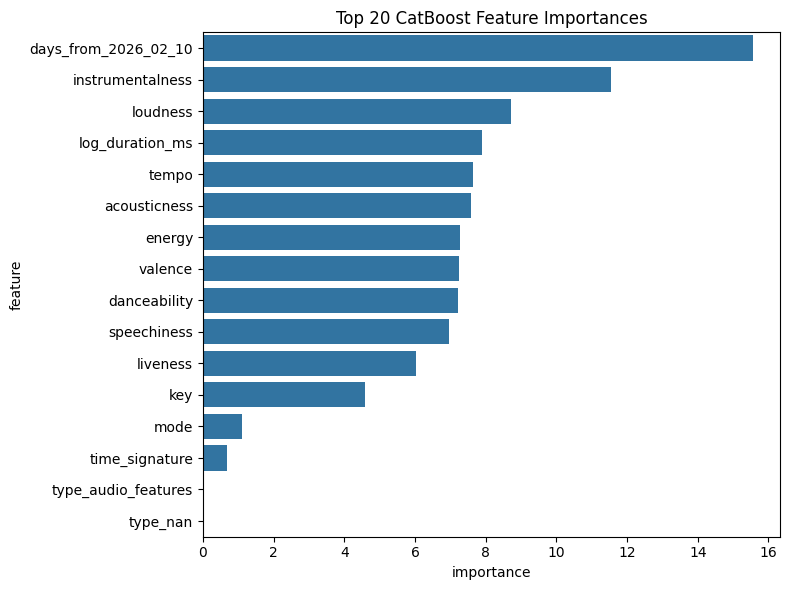

In [ ]:
# CatBoost Grid Search with early stopping per CV fold
cat_params = {
    'depth': [7],
    'learning_rate': [0.017],
    'l2_leaf_reg': [3],
    'subsample': [0.6],
    'bagging_temperature': [1.0],
    'min_data_in_leaf': [10],
    'iterations': [3000]
}
# cat_params['depth']=[3,4,5,6,7,8,9,10]
# cat_params['learning_rate']=[0.01,0.02,0.03,0.04]
# cat_params['l2_leaf_reg']=[1,2,3,4,5,6,7,8]
# cat_params['iterations']=[2000,3000,4000]
# cat_params['bagging_temperature']=[0.1,0.5,1,2,5,10]
# cat_params['min_data_in_leaf']=[10,20,30,40]]
# cat_params['random_strength']=[0,0.5,1.0]

cat_results = []
cat_best_score = -np.inf
cat_best_params = None

for param in ParameterGrid(cat_params):
    fold_scores = []
    for fold_id, (train_idx, val_idx) in enumerate(skf.split(X, Y), start=1):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = Y[train_idx], Y[val_idx]

        model = CatBoostClassifier(
            loss_function='Logloss',
            eval_metric='AUC',
            random_seed=2000 + fold_id,
            verbose=False,
            **param,
        )
        model.fit(
            X_train,
            y_train,
            eval_set=(X_val, y_val)
        )

        preds = model.predict_proba(X_val)[:, 1]
        fold_scores.append(roc_auc_score(y_val, preds))

    mean_score = float(np.mean(fold_scores))
    std_score = float(np.std(fold_scores))
    print(f"cat_params={param} mean_auc={mean_score:.6f} std_auc={std_score:.6f}")

    cat_results.append({
        'params': param,
        'mean_auc': mean_score,
        'std_auc': std_score,
        'fold_auc': fold_scores,
    })

    if mean_score > cat_best_score:
        cat_best_score = mean_score
        cat_best_params = param

print(cat_best_params)

# CatBoost feature importance (gain-style)
if cat_best_params is not None:
    cat_final = CatBoostClassifier(
        loss_function='Logloss',
        eval_metric='AUC',
        random_seed=2000,
        verbose=False,
        **cat_best_params,
    )
    cat_final.fit(X, Y)

    importances = cat_final.get_feature_importance(type='PredictionValuesChange')
    if importances is not None:
        imp = (
            pd.DataFrame({'feature': X.columns, 'importance': importances})
            .sort_values('importance', ascending=False)
            .head(20)
        )
        plt.figure(figsize=(8, 6))
        sns.barplot(data=imp, x='importance', y='feature')
        plt.title('Top 20 CatBoost Feature Importances')
        plt.tight_layout()
        plt.show()


In [147]:
# OOF ensemble weight search (XGB + CatBoost)
if best_params is None:
    raise ValueError('best_params is None. Run XGB grid search cell first.')
if cat_best_params is None:
    raise ValueError('cat_best_params is None. Run CatBoost grid search cell first.')

oof_xgb = np.zeros(len(Y))
oof_cat = np.zeros(len(Y))

for fold_id, (train_idx, val_idx) in enumerate(skf.split(X, Y), start=1):
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = Y[train_idx], Y[val_idx]

    xgb_model = XGBClassifier(
        objective='binary:logistic',
        eval_metric='auc',
        tree_method='hist',
        random_state=1000 + fold_id,
        n_jobs=4,
        **best_params,
    )
    xgb_model.fit(
        X_train,
        y_train,
        eval_set=[(X_val, y_val)],
        verbose=False,
    )
    oof_xgb[val_idx] = xgb_model.predict_proba(X_val)[:, 1]

    cat_model = CatBoostClassifier(
        loss_function='Logloss',
        eval_metric='AUC',
        random_seed=2000 + fold_id,
        verbose=False,
        **cat_best_params,
    )
    cat_model.fit(
        X_train,
        y_train,
        eval_set=(X_val, y_val),
        early_stopping_rounds=50,
    )
    oof_cat[val_idx] = cat_model.predict_proba(X_val)[:, 1]

best_w = None
best_auc = -np.inf
for w in np.arange(0.0, 1.0001, 0.05):
    oof_ens = w * oof_xgb + (1.0 - w) * oof_cat
    auc = roc_auc_score(Y, oof_ens)
    if auc > best_auc:
        best_auc = auc
        best_w = w
    print(f'weight_xgb={w:.2f} auc={auc:.6f}')

print(f'Best weight_xgb={best_w:.2f} auc={best_auc:.6f}')


weight_xgb=0.00 auc=0.834475
weight_xgb=0.05 auc=0.835417
weight_xgb=0.10 auc=0.836315
weight_xgb=0.15 auc=0.837103
weight_xgb=0.20 auc=0.837768
weight_xgb=0.25 auc=0.838416
weight_xgb=0.30 auc=0.838914
weight_xgb=0.35 auc=0.839275
weight_xgb=0.40 auc=0.839674
weight_xgb=0.45 auc=0.839949
weight_xgb=0.50 auc=0.840177
weight_xgb=0.55 auc=0.840297
weight_xgb=0.60 auc=0.840349
weight_xgb=0.65 auc=0.840339
weight_xgb=0.70 auc=0.840231
weight_xgb=0.75 auc=0.840101
weight_xgb=0.80 auc=0.839932
weight_xgb=0.85 auc=0.839644
weight_xgb=0.90 auc=0.839352
weight_xgb=0.95 auc=0.838983
weight_xgb=1.00 auc=0.838596
Best weight_xgb=0.60 auc=0.840349


In [149]:
# Train final models on full data and create submission.csv (XGB + CatBoost ensemble)
if best_params is None:
    raise ValueError('best_params is None. Run XGB grid search cell first.')
if cat_best_params is None:
    raise ValueError('cat_best_params is None. Run CatBoost grid search cell first.')

xgb_final = XGBClassifier(
    objective='binary:logistic',
    eval_metric='auc',
    tree_method='hist',
    random_state=0,
    n_jobs=4,
    **best_params,
)
xgb_final.fit(X, Y, verbose=False)

cat_final = CatBoostClassifier(
    loss_function='Logloss',
    eval_metric='AUC',
    random_seed=2000,
    verbose=False,
    **cat_best_params,
)
cat_final.fit(X, Y)

# Load and preprocess test data in the same way as train
raw_test_df = _read_csv(paths.data_dir, paths.test_csv)
if 'ID' not in raw_test_df.columns:
    raise ValueError("Expected 'ID' column in test.csv")

feature_test_df = raw_test_df.drop(columns=['ID'])

if 'duration_ms' in feature_test_df.columns:
    feature_test_df['log_duration_ms'] = np.log1p(feature_test_df['duration_ms'])
    feature_test_df = feature_test_df.drop(columns=['duration_ms'])

# Apply date feature engineering
date_col = 'track_album_release_date'
feature_test_df = _add_date_features(feature_test_df, date_col)

# Align categorical columns with train (one-hot)
X_train_full, _ = load_train(paths)
feature_test_df = pd.get_dummies(
    feature_test_df,
    columns=[c for c in feature_test_df.columns if feature_test_df[c].dtype == 'object'],
    dummy_na=True,
)
feature_test_df = feature_test_df.reindex(columns=X_train_full.columns, fill_value=0)

# Predict and ensemble
p_xgb = xgb_final.predict_proba(feature_test_df)[:, 1]
p_cat = cat_final.predict_proba(feature_test_df)[:, 1]
p_test = 0.6 * p_xgb + 0.4 * p_cat

if len(p_test) != len(raw_test_df):
    raise ValueError(
        f"Prediction length {len(p_test)} does not match test rows {len(raw_test_df)}"
    )

sub = pd.DataFrame({'ID': raw_test_df['ID'], TARGET_COL: p_test})
output_path = Path(paths.output_dir)
output_path.mkdir(parents=True, exist_ok=True)
out_file = output_path / paths.submission_csv
sub.to_csv(out_file, index=False)
print(f'Wrote: {out_file}')


Wrote: outputs/submission.csv
